<a href="https://colab.research.google.com/github/dhawaldarji7/BoolQ/blob/main/Submission1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [111]:
!pip install torch torchvision
!pip install transformers==2.5.1
!pip install pandas
!pip install numpy

!gsutil cp gs://boolq/train.jsonl .
!gsutil cp gs://boolq/dev.jsonl .

Copying gs://boolq/train.jsonl...
- [1 files][  6.2 MiB/  6.2 MiB]                                                
Operation completed over 1 objects/6.2 MiB.                                      
Copying gs://boolq/dev.jsonl...
- [1 files][  2.1 MiB/  2.1 MiB]                                                
Operation completed over 1 objects/2.1 MiB.                                      


In [112]:
import random
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW

In [113]:
# Loading data
train_data_df = pd.read_json("/content/train.jsonl", lines=True, orient='records')
dev_data_df = pd.read_json("/content/dev.jsonl", lines=True, orient="records")

In [114]:
dev_data_df

,question,title,answer,passage
0,does ethanol take more energy make that produces,Ethanol fuel,False,All biomass goes through at least some of thes...
1,is house tax and property tax are same,Property tax,True,Property tax or 'house tax' is a local tax on ...
2,is pain experienced in a missing body part or ...,Phantom pain,True,Phantom pain sensations are described as perce...
3,is harry potter and the escape from gringotts ...,Harry Potter and the Escape from Gringotts,True,Harry Potter and the Escape from Gringotts is ...
4,is there a difference between hydroxyzine hcl ...,Hydroxyzine,True,Hydroxyzine preparations require a doctor's pr...
...,...,...,...,...
3265,is manic depression the same as bi polar,Bipolar disorder,True,"Bipolar disorder, previously known as manic de..."
3266,was whiskey galore based on a true story,SS Politician,True,SS Politician was an 8000-ton cargo ship owned...
3267,are there plants on the international space st...,Plants in space,True,Plant research continued on the International ...
3268,does the hockey puck have to cross the line to...,Goal (ice hockey),True,"In ice hockey, a goal is scored when the puck ..."


In [116]:
passages_train = train_data_df.passage.values
questions_train = train_data_df.question.values
answers_train = train_data_df.answer.values.astype(int)
passages_dev = dev_data_df.passage.values
questions_dev = dev_data_df.question.values
answers_dev = dev_data_df.answer.values.astype(int)

In [117]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import wordnet

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [118]:
print(passages_train)
import nltk
nltk.download('averaged_perceptron_tagger')
   

['Persian (/ˈpɜːrʒən, -ʃən/), also known by its endonym Farsi (فارسی fārsi (fɒːɾˈsiː) ( listen)), is one of the Western Iranian languages within the Indo-Iranian branch of the Indo-European language family. It is primarily spoken in Iran, Afghanistan (officially known as Dari since 1958), and Tajikistan (officially known as Tajiki since the Soviet era), and some other regions which historically were Persianate societies and considered part of Greater Iran. It is written in the Persian alphabet, a modified variant of the Arabic script, which itself evolved from the Aramaic alphabet.'
 "Good Samaritan laws offer legal protection to people who give reasonable assistance to those who are, or who they believe to be, injured, ill, in peril, or otherwise incapacitated. The protection is intended to reduce bystanders' hesitation to assist, for fear of being sued or prosecuted for unintentional injury or wrongful death. An example of such a law in common-law areas of Canada: a good Samaritan do

True

In [64]:
#for sent in questions_train:
  #print(sent.split()[0])

In [119]:
#selecting the important question words that is verb or noun or the starting question word
#This is only for selecting the sentences from the passages.
array = []
for sent in questions_train[0:9427]:
    rows = []
    question_word =""
    question_word = sent.split()[0]
    tokenize_word = word_tokenize(sent)
    tagged = nltk.pos_tag(tokenize_word)
    for word, tag in tagged:
      if tag in ('NN', 'VB'):
        rows.append(word)
        rows.append(word.capitalize())
        #or (word == sent.split()[0])
        #rows.append(tuple((word,tag)))
        #rows.append(tuple((word.capitalize(),tag)))
    
    array.append(rows)
print(array[3])

#This will be used for making features from the questions and passages.
array_ques = []
for sent in questions_train[0:9427]:
    rows = []
    question_word =""
    question_word = sent.split()[0]
    tokenize_word = word_tokenize(sent)
    tagged = nltk.pos_tag(tokenize_word)
    for word, tag in tagged:
      if tag in ('NN', 'VB') or (word == sent.split()[0]):
        rows.append(word)
        rows.append(word.capitalize())
        #or (word == sent.split()[0])
        #rows.append(tuple((word,tag)))
        #rows.append(tuple((word.capitalize(),tag)))
    
    array_ques.append(rows)
print(array_ques[3])

['sugar', 'Sugar', 'sugar', 'Sugar']
['is', 'Is', 'sugar', 'Sugar', 'sugar', 'Sugar']


In [120]:
for word in array[1]:
  print(word)

do
Do
samaritan
Samaritan
accident
Accident


In [121]:
#selection of passage lines with the given shortlisted words from question
double_passage_line = []
for i in range(0,9427):
  passage_line = ""
  sentences = sent_tokenize(passages_train[i])
  for sent in sentences:
    if any(word in sent for word in array[i]):
      passage_line += sent
  #print(passage_line)
  double_passage_line.append(passage_line)

print(len(double_passage_line))
  
    
    

9427


In [122]:
print(passages_train)

['Persian (/ˈpɜːrʒən, -ʃən/), also known by its endonym Farsi (فارسی fārsi (fɒːɾˈsiː) ( listen)), is one of the Western Iranian languages within the Indo-Iranian branch of the Indo-European language family. It is primarily spoken in Iran, Afghanistan (officially known as Dari since 1958), and Tajikistan (officially known as Tajiki since the Soviet era), and some other regions which historically were Persianate societies and considered part of Greater Iran. It is written in the Persian alphabet, a modified variant of the Arabic script, which itself evolved from the Aramaic alphabet.'
 "Good Samaritan laws offer legal protection to people who give reasonable assistance to those who are, or who they believe to be, injured, ill, in peril, or otherwise incapacitated. The protection is intended to reduce bystanders' hesitation to assist, for fear of being sued or prosecuted for unintentional injury or wrongful death. An example of such a law in common-law areas of Canada: a good Samaritan do

In [123]:
print(array[5])

['use', 'Use', 'card', 'Card', 'station', 'Station']


In [124]:

rows, cols = (9427, 2) 

arr=[]
for i in range(rows):
  row = []
  for j in range(cols):
    if j==0:
      tokenize_word = word_tokenize(questions_train[i])
      tagged = nltk.pos_tag(tokenize_word)
      row.append(tagged)
    else:
      #tokenize_word = double_passage_line[i]
      tokenize_word = word_tokenize(double_passage_line[i])
      #tagged = nltk.pos_tag(tokenize_word)
      row.append(tokenize_word)
  arr.append(row)





In [30]:
!pip install -U bert-serving-server bert-serving-client

     |████████████████████████████████| 71kB 3.2MB/s 
  Created wheel for GPUtil: filename=GPUtil-1.4.0-cp37-none-any.whl size=7411 sha256=fe51284cf6d9d421999f732abe39cbd9aa6589e1f7a0b91c40035991c59010f6
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built GPUtil


In [126]:
#function for checking the negative question verb 
def negation_check(first_word, sentence):
  #print(first_word)
  #print(sentence)
  val = 0
  
  for word in sentence:
    #print(word)
    if first_word == " will " and (word == "won't" or word == "Won't") :
      #print("1","present")
      val = 1
      break
    elif first_word == " can " and (word == "can't" or word == "Can't") :
      #print("1","present")
      val = 1
      break
    
    elif first_word == " do " and (word == "don't" or word == "Don't") :
      #print("1","present")
      val = 1
      break
  
    elif first_word == " are " and (word == "aren't" or word == "Aren't") :
      #print("1","present")
      val = 1
      break

    elif first_word == " does " and (word == "doesn't" or word == "Doesn't"):
      #print("2","present")
      val = 1
      break

    elif first_word == " is " and (word == "isn't" or word == "Isn't"):
      #print("3","present")
      val = 1
      break

    elif first_word == " was " and (word == "wasn't" or word == "Wasn't"):
      #print("5","present")
      val = 1
      break

    elif first_word == " were " and (word == "weren't" or word == "Weren't"):
      #print("6","present")
      val = 1
      break

    elif word == sentence[len(sentence)-1]:
      #print("not present")
      val = 0
      
    else:
      continue
  return val
    
      

In [127]:
#function checking for not in the passage
def not_check(sentence):
  val = 0
  for word in sentence:
    
    if word == "not":
      val = 1
      break
  return val


In [128]:
#function checking for verbs that are present in question are there in answer or not
def check_for_verb(verb, sentence):
  verb_present = 0
  for word, tag in verb[1:]:
    #print(word, tag)
    if tag == 'VBZ' or tag == 'VB' or tag == 'VBP':
      if word in sentence:
        verb_present = 1
        #print("verb is there")
        break
  return verb_present
  #print(sentence)

In [129]:
#checking whether last noun in question is present in the passage or not?
def check_for_last_noun(last_tuple, sentence):
  #print(last_tuple[1])
  #print(sentence)
  last_noun_present = 0
  if last_tuple[1] == 'NN' or last_tuple[1] == 'NNS' or last_tuple[1] == 'NNP':
    if last_tuple[0] in sentence:
      last_noun_present = 1
  return last_noun_present
  #print(sentence)

In [130]:
#function checking for similar verbs
def check_similar_verb(verb_sent, sentence):
  #print("verb_sent", verb_sent)
  #print(sentence)
  val = 0
  for word, tag in verb_sent:
    if tag == 'VBP':
      synonyms = [] 
      for syn_set in wordnet.synsets(word): 
        for l in syn_set.lemmas(): 
          synonyms.append(l.name()) 
      #print(word)
      #print(synonyms)
      #print()
      if any(word in sentence for word in synonyms):
        #print("present")
        val = 1
  return val
        


In [131]:
print(arr[1])

[[('do', 'VB'), ('good', 'JJ'), ('samaritan', 'VB'), ('laws', 'NNS'), ('protect', 'VBP'), ('those', 'DT'), ('who', 'WP'), ('help', 'VBP'), ('at', 'IN'), ('an', 'DT'), ('accident', 'NN')], ['Good', 'Samaritan', 'laws', 'offer', 'legal', 'protection', 'to', 'people', 'who', 'give', 'reasonable', 'assistance', 'to', 'those', 'who', 'are', ',', 'or', 'who', 'they', 'believe', 'to', 'be', ',', 'injured', ',', 'ill', ',', 'in', 'peril', ',', 'or', 'otherwise', 'incapacitated.An', 'example', 'of', 'such', 'a', 'law', 'in', 'common-law', 'areas', 'of', 'Canada', ':', 'a', 'good', 'Samaritan', 'doctrine', 'is', 'a', 'legal', 'principle', 'that', 'prevents', 'a', 'rescuer', 'who', 'has', 'voluntarily', 'helped', 'a', 'victim', 'in', 'distress', 'from', 'being', 'successfully', 'sued', 'for', 'wrongdoing.By', 'contrast', ',', 'a', 'duty', 'to', 'rescue', 'law', 'requires', 'people', 'to', 'offer', 'assistance', 'and', 'holds', 'those', 'who', 'fail', 'to', 'do', 'so', 'liable', '.']]


In [132]:
#function for making the data using the given set of features
def features(value, index):
    """Set of four features from lecture"""
    #feature1 checking for the negation word
    
    #print("0th value",value[1])
    negation = 0
    negation = negation_check(value[0][0][0], value[1])
    #feature2 checking for not
    not_word = 0
    not_word = not_check(value[1])
    #checking for VB present in ans or not.
    verb_check = 0
    verb_check = check_for_verb(value[0], value[1])
    #checking for the last noun
    last_noun = 0
    ques_len = len(value[0])
    last_noun = check_for_last_noun(value[0][ques_len-1], value[1])
    
    #check for similarity between the verbs present in question and answer
    similar_verb = 0
    if (verb_check==0):
      similar_verb = check_similar_verb(value[0], value[1])
    #checking for all the nouns present in the passage or not
    all_nouns = 0
    #all_nouns = 
    #bias
    f1 = 1 if negation is 1 else 0
    f2 = 1 if not_word is 1 else 0
    f3 = 1 if verb_check is 1 else 0
    f4 = 1 if last_noun is 1 else 0
    f5 = 1 if similar_verb is 1 else 0
    f6 = 1
    return np.array([f1, f2, f3, f4, f5, f6])    

feature_matrix = [[0,0,0,0,0,0]]
for i in range(0,9427):
    a = np.array(feature_matrix)
    b = np.array([features(arr[i],i)])
    #print(a)
    #print(b)
    feature_matrix = np.concatenate((a,b), axis=0)
feature_matrix = feature_matrix[1:]
print(len(feature_matrix))
print(feature_matrix[9000:9020])

9427
[[0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 1 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 1 0 1]
 [0 0 0 1 0 1]
 [0 0 0 1 0 1]
 [0 1 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 1 1 1]
 [0 0 0 1 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 1 1 1 0 1]
 [0 0 0 1 0 1]
 [0 1 1 0 0 1]
 [0 0 0 1 0 1]]


In [133]:
feature_matrix.shape

(9427, 6)

In [157]:
import tensorflow as tf
#import keras
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

In [158]:
#selecting the important question words that is verb or noun or the starting question word
#This is only for selecting the sentences from the passages.
array = []
for sent in questions_dev[0:3270]:
    rows = []
    question_word =""
    question_word = sent.split()[0]
    tokenize_word = word_tokenize(sent)
    tagged = nltk.pos_tag(tokenize_word)
    for word, tag in tagged:
      if tag in ('NN', 'VB'):
        rows.append(word)
        rows.append(word.capitalize())
        #or (word == sent.split()[0])
        #rows.append(tuple((word,tag)))
        #rows.append(tuple((word.capitalize(),tag)))
    
    array.append(rows)
print(array[3])

#This will be used for making features from the questions and passages.
array_ques = []
for sent in questions_dev[0:3270]:
    rows = []
    question_word =""
    question_word = sent.split()[0]
    tokenize_word = word_tokenize(sent)
    tagged = nltk.pos_tag(tokenize_word)
    for word, tag in tagged:
      if tag in ('NN', 'VB') or (word == sent.split()[0]):
        rows.append(word)
        rows.append(word.capitalize())
        #or (word == sent.split()[0])
        #rows.append(tuple((word,tag)))
        #rows.append(tuple((word.capitalize(),tag)))
    
    array_ques.append(rows)
print(array_ques[3])

['potter', 'Potter', 'escape', 'Escape', 'gringotts', 'Gringotts', 'roller', 'Roller', 'coaster', 'Coaster', 'ride', 'Ride']
['is', 'Is', 'potter', 'Potter', 'escape', 'Escape', 'gringotts', 'Gringotts', 'roller', 'Roller', 'coaster', 'Coaster', 'ride', 'Ride']


In [159]:
#selection of passage lines with the given shortlisted words from question
double_passage_line = []
for i in range(0,3270):
  passage_line = ""
  sentences = sent_tokenize(passages_dev[i])
  for sent in sentences:
    if any(word in sent for word in array[i]):
      passage_line += sent
  #print(passage_line)
  double_passage_line.append(passage_line)

print(len(double_passage_line))

3270


In [161]:
#print(passages_train[0])
#print(questions_train[0])

rows, cols = (3270, 2) 

arr=[]
for i in range(rows):
  row = []
  for j in range(cols):
    if j==0:
      tokenize_word = word_tokenize(questions_dev[i])
      tagged = nltk.pos_tag(tokenize_word)
      row.append(tagged)
    else:
      #tokenize_word = double_passage_line[i]
      tokenize_word = word_tokenize(double_passage_line[i])
      #tagged = nltk.pos_tag(tokenize_word)
      row.append(tokenize_word)
  arr.append(row)

In [162]:
print(arr[0])

[[('does', 'VBZ'), ('ethanol', 'VB'), ('take', 'VB'), ('more', 'JJR'), ('energy', 'NN'), ('make', 'VBP'), ('that', 'IN'), ('produces', 'NNS')], ['The', 'total', 'amount', 'of', 'energy', 'input', 'into', 'the', 'process', 'compared', 'to', 'the', 'energy', 'released', 'by', 'burning', 'the', 'resulting', 'ethanol', 'fuel', 'is', 'known', 'as', 'the', 'energy', 'balance', '(', 'or', '``', 'energy', 'returned', 'on', 'energy', 'invested', "''", ')', '.Figures', 'compiled', 'in', 'a', '2007', 'report', 'by', 'National', 'Geographic', 'Magazine', 'point', 'to', 'modest', 'results', 'for', 'corn', 'ethanol', 'produced', 'in', 'the', 'US', ':', 'one', 'unit', 'of', 'fossil-fuel', 'energy', 'is', 'required', 'to', 'create', '1.3', 'energy', 'units', 'from', 'the', 'resulting', 'ethanol.The', 'energy', 'balance', 'for', 'sugarcane', 'ethanol', 'produced', 'in', 'Brazil', 'is', 'more', 'favorable', ',', 'with', 'one', 'unit', 'of', 'fossil-fuel', 'energy', 'required', 'to', 'create', '8', 'from

In [163]:
feature_matrix_dev = [[0,0,0,0,0,0]]
for i in range(0,3270):
    a = np.array(feature_matrix_dev)
    b = np.array([features(arr[i],i)])
    #print(a)
    #print(b)
    feature_matrix_dev = np.concatenate((a,b), axis=0)
feature_matrix_dev = feature_matrix_dev[1:]
print(len(feature_matrix_dev))
print(feature_matrix_dev[3000:3020])

3270
[[0 0 0 0 0 1]
 [0 0 1 0 0 1]
 [0 0 0 1 0 1]
 [0 0 1 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 1 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 1 0 1]
 [0 0 1 1 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 1 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 1 1]
 [0 0 0 0 0 1]]


In [164]:
#model5 is the Bidirectional Lstm applied with 1 embedding layer, 2 bidirectional layers and 1 output layer
inputs5 = keras.Input(shape=(6,), dtype="int32")
x5 = layers.Embedding(9427, 6)(inputs5)
x5 = layers.Bidirectional(layers.LSTM(50, return_sequences=True))(x5)
x5 = layers.Bidirectional(layers.LSTM(50))(x5)
outputs5 = layers.Dense(2, activation="softmax")(x5)
model5 = keras.Model(inputs5, outputs5)
model5.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 6, 6)              56562     
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 6, 100)            22800     
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 100)               60400     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 202       
Total params: 139,964
Trainable params: 139,964
Non-trainable params: 0
_________________________________________________________________


In [165]:
model5.compile("adam", "categorical_crossentropy", metrics=["accuracy"])

In [166]:
model5.fit(
  feature_matrix,
  to_categorical(answers_train),
  epochs=15,
  batch_size=32
)

Epoch 1/15
295/295 [==============================] - 10s 14ms/step - loss: 0.6684 - accuracy: 0.6145
Epoch 2/15
295/295 [==============================] - 4s 14ms/step - loss: 0.6661 - accuracy: 0.6157
Epoch 3/15
295/295 [==============================] - 4s 14ms/step - loss: 0.6603 - accuracy: 0.6251
Epoch 4/15
295/295 [==============================] - 4s 14ms/step - loss: 0.6597 - accuracy: 0.6273
Epoch 5/15
295/295 [==============================] - 4s 14ms/step - loss: 0.6580 - accuracy: 0.6259
Epoch 6/15
295/295 [==============================] - 4s 14ms/step - loss: 0.6603 - accuracy: 0.6236
Epoch 7/15
295/295 [==============================] - 4s 14ms/step - loss: 0.6641 - accuracy: 0.6156
Epoch 8/15
295/295 [==============================] - 4s 14ms/step - loss: 0.6574 - accuracy: 0.6218
Epoch 9/15
295/295 [==============================] - 4s 14ms/step - loss: 0.6562 - accuracy: 0.6240
Epoch 10/15
295/295 [==============================] - 4s 14ms/step - loss: 0.6599 - accur

In [167]:
model5.evaluate(
  feature_matrix_dev,
  to_categorical(answers_dev)
)

103/103 [==============================] - 2s 4ms/step - loss: 0.6569 - accuracy: 0.6275


[0.6569253206253052, 0.6275229454040527]

In [168]:
predictions5 = model5.predict(feature_matrix_dev)

In [169]:
y_pred5 = np.argmax(predictions5, axis=1)
y_pred5[0:30]

array([1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [217]:
#model is the model containing 1 embedding layer, 1 lstm layer, 2 dense relu layers, 1 output layer with sigmoid activation function
model = keras.Sequential()
model.add(layers.Embedding(input_dim=9427, output_dim=64))
# Add a LSTM layer with 128 internal units.
model.add(layers.LSTM(100))
model.add(layers.Dense(20, activation="relu"))
model.add(layers.Dense(10, activation="relu"))
model.add(layers.Dense(2, activation="sigmoid"))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 64)          603328    
_________________________________________________________________
lstm_16 (LSTM)               (None, 100)               66000     
_________________________________________________________________
dense_17 (Dense)             (None, 20)                2020      
_________________________________________________________________
dense_18 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 22        
Total params: 671,580
Trainable params: 671,580
Non-trainable params: 0
_________________________________________________________________


In [218]:
model.compile("adam", "categorical_crossentropy", metrics=["accuracy"])

In [219]:
model.fit(
  feature_matrix,
  to_categorical(answers_train),
  epochs=20,
  batch_size=16
)

Epoch 1/20
590/590 [==============================] - 10s 14ms/step - loss: 0.6682 - accuracy: 0.6305
Epoch 2/20
590/590 [==============================] - 8s 14ms/step - loss: 0.6585 - accuracy: 0.6354
Epoch 3/20
590/590 [==============================] - 8s 14ms/step - loss: 0.6585 - accuracy: 0.6239
Epoch 4/20
590/590 [==============================] - 8s 14ms/step - loss: 0.6562 - accuracy: 0.6298
Epoch 5/20
590/590 [==============================] - 8s 14ms/step - loss: 0.6574 - accuracy: 0.6266
Epoch 6/20
590/590 [==============================] - 8s 14ms/step - loss: 0.6542 - accuracy: 0.6300
Epoch 7/20
590/590 [==============================] - 8s 14ms/step - loss: 0.6580 - accuracy: 0.6224
Epoch 8/20
590/590 [==============================] - 8s 14ms/step - loss: 0.6626 - accuracy: 0.6138
Epoch 9/20
590/590 [==============================] - 8s 14ms/step - loss: 0.6557 - accuracy: 0.6279
Epoch 10/20
590/590 [==============================] - 8s 14ms/step - loss: 0.6557 - accur

In [220]:
model.evaluate(
  feature_matrix_dev,
  to_categorical(answers_dev)
)

103/103 [==============================] - 1s 3ms/step - loss: 0.6575 - accuracy: 0.6229


[0.6575310826301575, 0.6229357719421387]

In [221]:
predictions = model.predict(feature_matrix_dev)

In [222]:
y_pred = np.argmax(predictions, axis=1)

In [223]:
y_pred[3000:3200]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [251]:
#f1 score for both the models
from sklearn.metrics import f1_score
score_lstm = f1_score(y_pred, answers_dev, average='weighted')
score_bidirectional = f1_score(y_pred5, answers_dev, average='weighted')
print("f1 score for bidirectional LSTM", score_bidirectional)
print("f1 score for LSTM", score_lstm)

f1 score for bidirectional LSTM 0.7185796904685458
f1 score for LSTM 0.7271327505486


In [230]:
!pip install scikit-plot

3270 3270


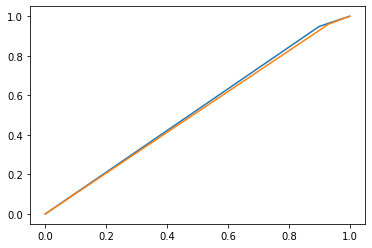

In [250]:
#plotting Roc curve for both the models
import scikitplot as skplt
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt1
from sklearn.metrics import roc_curve
arr_dev = []
arr_pred = []
arr_predict = []
for i in range(3270):
  arr_dev.append(answers_dev[i])
  arr_pred.append(y_pred[i])
  arr_predict.append(y_pred5[i])

print(len(arr_dev), len(arr_pred))
#print(arr_dev.shape, arr_pred.shape)
#y_true = # ground truth labels
#y_probas = # predicted probabilities generated by sklearn classifier
fpr, tpr, thresholds = roc_curve(arr_dev, arr_pred)
fpr1, tpr1, thresholds = roc_curve(arr_dev, arr_predict)
plt.plot(fpr1, tpr1)
#plt.show()
plt1.plot(fpr, tpr)
#plt1.show()